In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("TimeSeries.csv")
label_df = pd.read_csv("labelsTimeSeries.csv")

In [11]:
df.shape

(509632, 11)

In [4]:
df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11
0,-2.00,1.51,10.14,0.0,0.0,0.0,-15.78,-22.31,-11.70,-13.57,92.95
1,-2.00,1.51,10.13,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95
2,-2.00,1.51,10.13,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95
3,-1.99,1.51,10.17,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95
4,-1.99,1.51,10.17,0.0,0.0,0.0,-16.86,-23.38,-10.31,-13.57,92.95


In [5]:
df.describe()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11
count,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000,509632.000000
mean,-4.970240,-3.346117,1.932129,0.001911,0.002468,0.000450,42.773530,30.240553,-17.209860,-18.630128,28.974269
std,4.561687,6.118350,7.651674,0.215727,0.344642,0.172834,76.652202,64.720827,89.829919,19.805768,57.411149
min,-79.810000,-87.900000,-87.650000,-3.840000,-5.990000,-6.600000,-275.720000,-289.300000,-325.230000,-89.200000,-176.250000
25%,-8.860000,-5.050000,-1.200000,0.000000,0.000000,0.000000,7.120000,0.000000,-15.160000,-34.870000,-7.150000
50%,-2.750000,-3.090000,0.120000,0.000000,0.000000,0.000000,46.090000,15.860000,1.040000,-14.960000,-0.120000
75%,-1.090000,1.330000,9.480000,0.000000,0.010000,0.000000,60.340000,22.130000,11.440000,-8.130000,92.780000
max,78.900000,78.880000,76.830000,4.800000,5.830000,3.890000,306.760000,318.200000,323.020000,65.270000,179.430000


In [6]:
label_df.head()

,label
0,0
1,0
2,0
3,0
4,0


In [7]:
label_df.shape

(509632, 1)

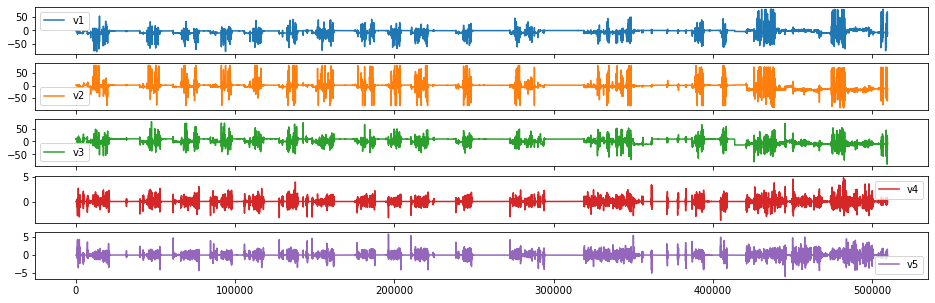

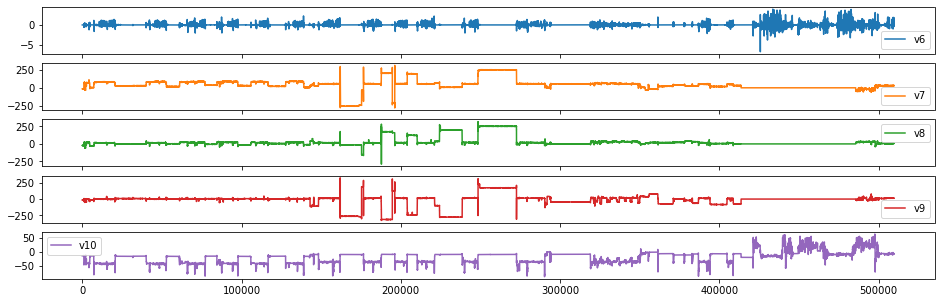

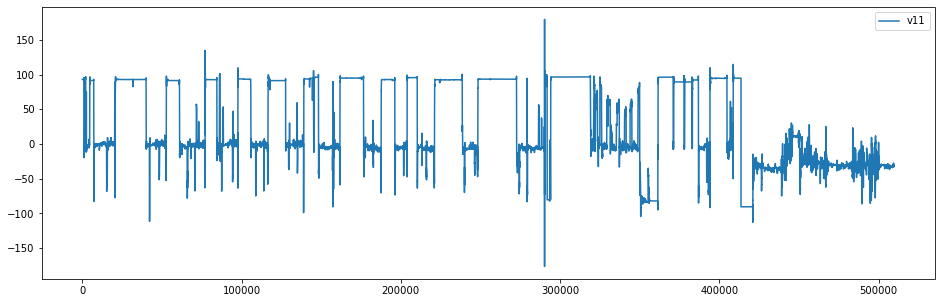

In [8]:
for k in range(0, df.shape[1],5):
    df.iloc[:, k:k+5].plot(figsize = (16, 5), subplots=True)

<AxesSubplot:>

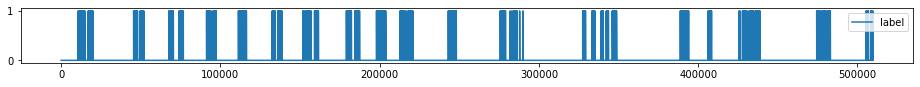

In [9]:
label_df.plot(figsize = (16, 1))

In [82]:
label_df.value_counts()

label
0        509189
1           443
dtype: int64

In [83]:
from scipy import stats
from sklearn import preprocessing

In [84]:
df['y'] = label_df['label']
df['y'].value_counts()

0    509189
1       443
Name: y, dtype: int64

In [85]:
# Define a size for your train set 
train_size = int(0.7 * len(df))

# Split your dataset 
train_data = df[df['y'] == 0][:train_size]
test_data = df[train_size:]

In [86]:
train_data.drop(columns=['y'], inplace=True)
test_data.drop(columns=['y'], inplace=True)

In [87]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(train_data), 
                              columns = train_data.columns, 
                              index = train_data.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(test_data), 
                             columns = test_data.columns, 
                             index = test_data.index)

In [88]:
# covariance matrix calculation

def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

# Mahalanobis distance calculation


def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

# outlier detection


def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

# threshold value calculation for classifying datapoint as anomaly


def MD_threshold(dist, std_dev=4, verbose=False):
    threshold = np.mean(dist) + np.std(dist) * std_dev
    return threshold

# Check if matrix is positive definite


def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [89]:
from sklearn.decomposition import PCA

# only keep the first 2 principal components
pca = PCA(n_components=2, svd_solver='full')

X_train_PCA = pca.fit_transform(X_train)
print(pca.explained_variance_)

[0.04962024 0.03612658]


In [90]:
# X_train_PCA shape: (num_training_examples x num_principal_components)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
# X_test_PCA shape: (num_test_examples x num_principal_components)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

# principal_components_train shape: (num_training_examples x num_principal_components)
principal_components_train = np.array(X_train_PCA.values)
# principal_components_test shape: (num_test_examples x num_principal_components)
principal_components_test = np.array(X_test_PCA.values)

In [91]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.43280663 0.31510974]


In [92]:
# Calculate the covariance matrix and its inverse, based principal components of training data
# cov_matrix/inv_cov_matrix shape: (num_principal_components x num_principal_components)
cov_matrix, inv_cov_matrix = cov_matrix(principal_components_train)

# calculate the mean value for the principal components of training set, as this is used later
# to calculate the Mahalanobis distance to datapoints in the test set
# mean_distr shape: (num_principal_components, )
mean_distr = principal_components_train.mean(axis=0)

# calculate the Mahalanobis distance for training set
# dist_train length: num_training_examples
dist_train = MahalanobisDist(
    inv_cov_matrix, mean_distr, principal_components_train, verbose=False)

# find the threshold value to flag datapoints as an anomaly based on training set
# threshold: a number, type numpy.float64
threshold = MD_threshold(dist_train, std_dev=2)

# calculate the Mahalanobis distance for test set, to be compared with the anomaly threshold
# dist_test length: num_test_examples
dist_test = MahalanobisDist(
    inv_cov_matrix, mean_distr, principal_components_test, verbose=False)

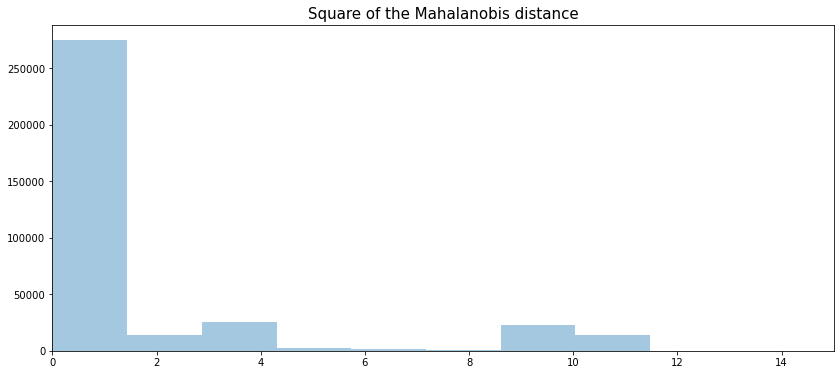

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.distplot(np.square(dist_train),
             bins=10,
             kde=False).set_title('Square of the Mahalanobis distance', fontsize=15)
plt.xlim([0.0, 15])
plt.show()

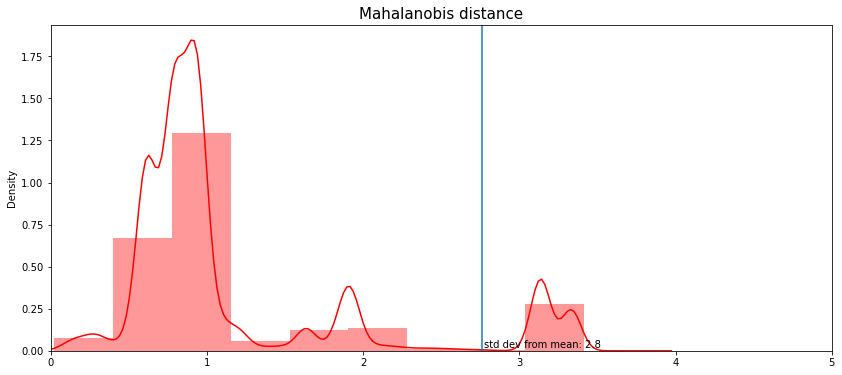

In [94]:
plt.figure(figsize=(14, 6))
sns.distplot(dist_train,
             bins=10,
             kde=True,
             color='red').set_title('Mahalanobis distance', fontsize=15)

plt.axvline(threshold)
plt.text(threshold + 0.01, 0.02, 'std dev from mean: ' +
         str(round(threshold, 1)))

plt.xlim([0.0, 5])
plt.show()

In [95]:
# save the Mahalanobis distance, as well as the threshold value and “anomaly flag” variable for both train and test data in a dataframe

anomaly_train = pd.DataFrame()
anomaly_train['Mob dist'] = dist_train
anomaly_train['Thresh'] = threshold

# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist'] = dist_test
anomaly['Thresh'] = threshold

# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
356742,0.553753,2.763186,False
356743,0.553753,2.763186,False
356744,0.553829,2.763186,False
356745,0.553829,2.763186,False
356746,0.548429,2.763186,False


In [96]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])

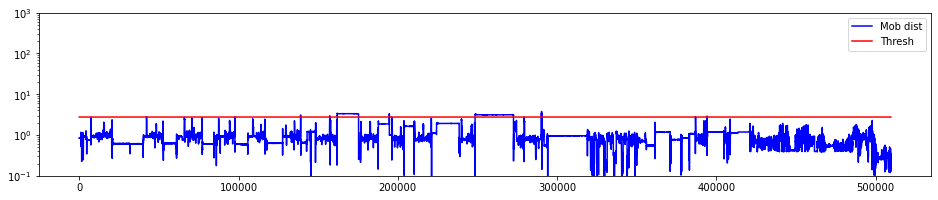

In [97]:
anomaly_alldata.plot(logy=True, figsize=(16, 3), ylim=[
                     1e-1, 1e3], color=['blue', 'red'])
plt.show()

<AxesSubplot:>

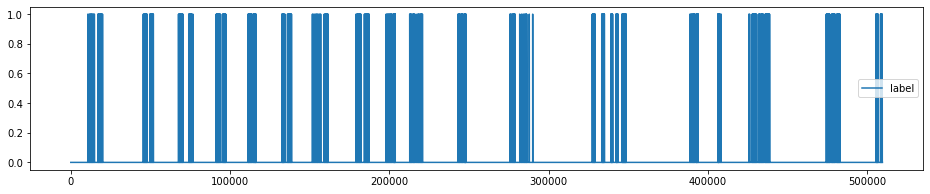

In [98]:
label_df.plot(figsize = (16, 3))